## Profiles of $N^2$, concentration $C$ and $\partial_zC$ at DnS station

The idea is to see how the profiles change in this location for different inital shapes, all with the same diffusivity.

In [2]:
import cmocean as cmo
import matplotlib.gridspec as gspec
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import canyon_tools.readout_tools as rout

In [3]:
def get_profile(dataset,tracer,times,mask,yi,xi):
    '''
    dataset : netcdf dataset e.g. dataset = Dataset(ptracersGlob.nc)
    tracers : tracer key in the dataset, e.g. 'Tr1'
    times : list of time indices at which to get profiles e.g. [0,4,10] would be days 0, 2 and 5. 
    mask : 1D mask size nz at point (yi,xi)
    yi : y index of station location
    xi : x index of station location
    
    OUTPUT: masked array size (len(times),nz) with profiles at 'times' for tracer 'tracer'.
    '''
    profile = np.ma.empty((len(times),np.shape(mask)[0]))
    ii = 0
        
    for tt in times:  
        profile_raw = dataset.variables[trac][tt,:,yi,xi]
        profile[ii,:] = np.ma.masked_array(profile_raw,mask=mask)
        ii = ii+1
    
    return profile          

In [4]:
def calc_N2(state_dset,times,mask,drC,yi,xi):
    '''
    state_dset : netcdf state file dataset e.g. state_dset = Dataset(stateGlob.nc)
    times : list of time indices at which to get profiles e.g. [0,4,10] would be days 0, 2 and 5. 
    mask : 1D mask size nz at point (yi,xi)
    drC : 1D vector with cell center distances dz.
    yi : y index of station location
    xi : x index of station location
    
    OUTPUT: masked array size (len(times),nz-2) with N**2 profiles at 'times'.
    '''
    RhoRef = 999.79998779 # It is constant throughout my runs
    g = 9.81 # ms^-2
    alpha = 2.0E-4 # 1/degC
    beta = 7.4E-4
  
    
    N2 = np.ma.empty((len(times),np.shape(mask)[0]-2))
    ii = 0
        
    for tt in times: 
        
        Temp_raw = state_dset['Temp'][tt,:,yi,xi]
        S_raw = state_dset['S'][tt,:,yi,xi]
        T = np.ma.array(Temp_raw,mask=mask)   
        S = np.ma.array(S_raw,mask=mask)   
     
        #Linear eq. of state 
        rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T) + beta*(S))
            
        # N^2 for each station
        N2[ii,:] = ((-g/RhoRef)*((rho[2:] - rho[:-2])/(-drC[3:]-drC[2:-1])))            
        ii = ii+1
        
    return(N2)
    

In [5]:
def calc_dTrdz(profile,drC):
    '''
    profile: 1D or 2D profile array with dimensions (time, z).
    drC : 1D vector with cell center distances dz.
    
    OUTPUT: dCdz, masked array size (len(times),nz-2) with dTr/dz profiles at 'times'.
    '''
    dCdz = ((profile[:,2:] - profile[:,:-2])/(-drC[3:]-drC[2:-1]))         
    return(dCdz)

### General inputs

In [6]:
# Datasets
Grid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc' 

StatePara = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run01/stateGlob.nc' 
StateBark = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/stateGlob.nc' 

PtracPara = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run01/ptracersGlob.nc' 
PtracBark = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc' 

GridOut = Dataset(Grid)

StateParaDS = Dataset(StatePara)
StateBarkDS = Dataset(StateBark)

PtracParaDS = Dataset(PtracPara)
PtracBarkDS = Dataset(PtracBark)

#Station DnS coordinates
yi = 245
xi = 200
station = 'DnC'

# 1D Mask at DnS and vertical spacing
mask = rout.getMask(Grid, 'HFacC')[:,yi,xi]
drC = GridOut.variables['drC'][:] # vertical distance between centers
depth = GridOut.variables['RC'][:]

In [7]:
sns.set_context('notebook')
sns.set_style('whitegrid')

 ## Big picture plot

Parabolic: Tr1 13.625 12.593542099 -0.05
Parabolic: Tr2 13.6272497177 12.8862714767 -0.0553999900818
Parabolic: Tr3 13.625369072 12.6462278366 -0.0508850097656
Parabolic: Tr4 13.624669075 12.5458850861 -0.0492049217224
Parabolic: Tr5 13.6231870651 12.3310260773 -0.0456500053406
Parabolic: Tr6 13.640625 15.1507253647 -0.0875
Parabolic: Tr7 150.109375 146.425231934 -0.0125
Barkley: Tr01 32.2426795959 32.208152771 -0.00167350769043
Barkley: Tr02 33.8938980103 33.8268852234 -0.00100326538086
Barkley: Tr03 104.070732117 112.498497009 0.186195373535
Barkley: Tr04 32.6079177856 31.6729812622 -0.0311317443848
Barkley: Tr05 47.6260147095 44.899017334 -0.047240447998
Barkley: Tr06 2.24576282501 2.17560553551 -0.00128390789032
Barkley: Tr07 27.6673622131 25.5802135468 -0.00670261383057
Barkley: Tr08 17.5046100616 16.2077999115 -0.375434303284


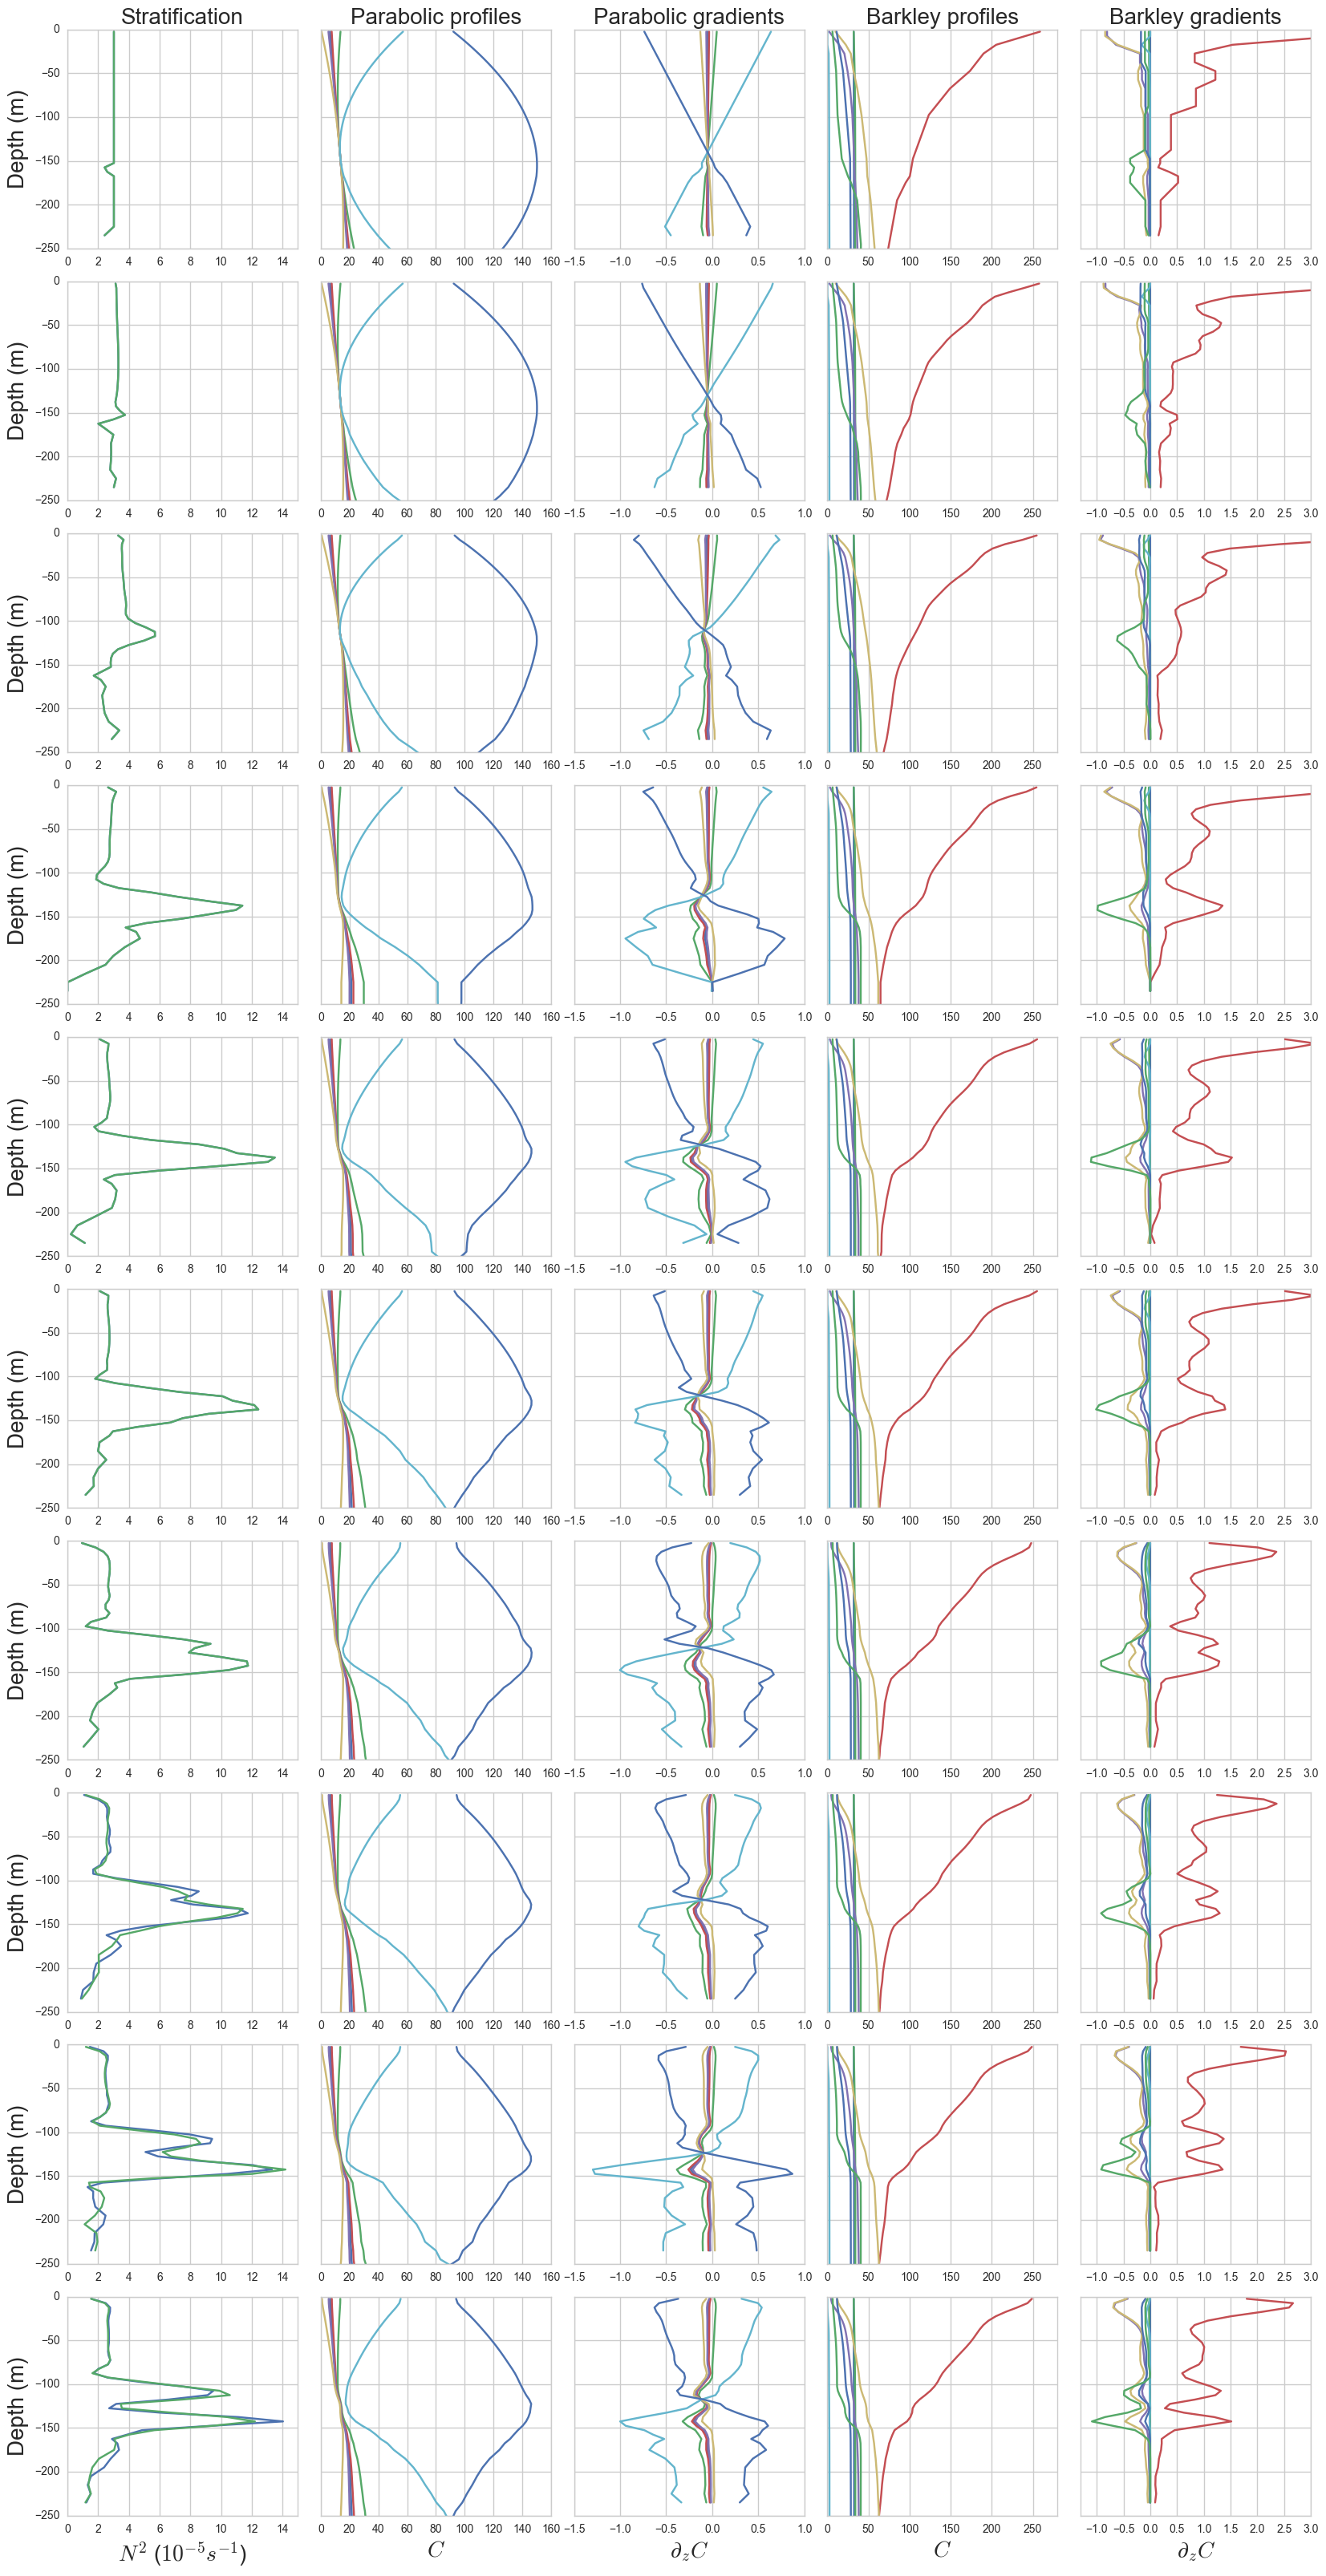

In [31]:
tracers_para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
tracers_bark = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']

times = [0,2,4,6,8,10,12,14,16,18]
nt = len(times)

fig = plt.figure(figsize=(20,40)) 
gs = gspec.GridSpec(nt, 5, hspace=0.15, wspace=0.1)


for trac in tracers_para:
    Tr = get_profile(PtracParaDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
    print('Parabolic:', trac, Tr[0,29], Tr[5,25] , dTr[0,29])     
    for tt,time in zip(range(nt),times):
        plt.subplot(gs[tt,1]).plot(Tr[tt,:],depth)
        plt.subplot(gs[tt,2]).plot(dTr[tt,:],depth[:-2])
        plt.subplot(gs[tt,1]).set_ylim(-250,0)
        plt.subplot(gs[tt,2]).set_ylim(-250,0)
        plt.subplot(gs[tt,2]).set_xlim(-1.5,1)
        plt.subplot(gs[tt,1]).set_xlim(0,160)
        plt.subplot(gs[tt,1]).set_yticklabels([])
        plt.subplot(gs[tt,2]).set_yticklabels([])
        
for trac in tracers_bark:
    Tr = get_profile(PtracBarkDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
    print('Barkley:', trac,Tr[0,29],Tr[5,25], dTr[0,29])    
    for tt,time in zip(range(nt),times):
        plt.subplot(gs[tt,3]).plot(Tr[tt,:],depth)
        plt.subplot(gs[tt,4]).plot(dTr[tt,:],depth[:-2],)
        plt.subplot(gs[tt,3]).set_ylim(-250,0)
        plt.subplot(gs[tt,4]).set_ylim(-250,0)
        plt.subplot(gs[tt,3]).set_xlim(0,280)
        plt.subplot(gs[tt,4]).set_xlim(-1.3,3)
        plt.subplot(gs[tt,3]).set_yticklabels([])
        plt.subplot(gs[tt,4]).set_yticklabels([])
       
    
N2_bark = calc_N2(StateBarkDS,times,mask,drC,yi,xi)
N2_para = calc_N2(StateParaDS,times,mask,drC,yi,xi)
        
for tt in range(nt):
    plt.subplot(gs[tt,0]).plot((N2_bark[tt,:])*1E5,depth[:-2],)
    plt.subplot(gs[tt,0]).plot((N2_para[tt,:])*1E5,depth[:-2],)

xlabels = ['$N^2$ ($10^{-5} s^{-1}$)','$C$','$\partial_zC$','$C$','$\partial_zC$']
for plot, xlabel in zip(range(5),xlabels):
    plt.subplot(gs[nt-1,plot]).set_xlabel(xlabel,fontsize=20)

titles = ['Stratification','Parabolic profiles','Parabolic gradients','Barkley profiles','Barkley gradients']
for plot, title in zip(range(5),titles):
    plt.subplot(gs[0,plot]).set_title(title,fontsize=20)

for tt in range(nt):
    plt.subplot(gs[tt,0]).set_ylabel('Depth (m)',fontsize=20)
    plt.subplot(gs[tt,0]).set_ylim(-250,0)
    plt.subplot(gs[tt,0]).set_xlim(0,15)
    




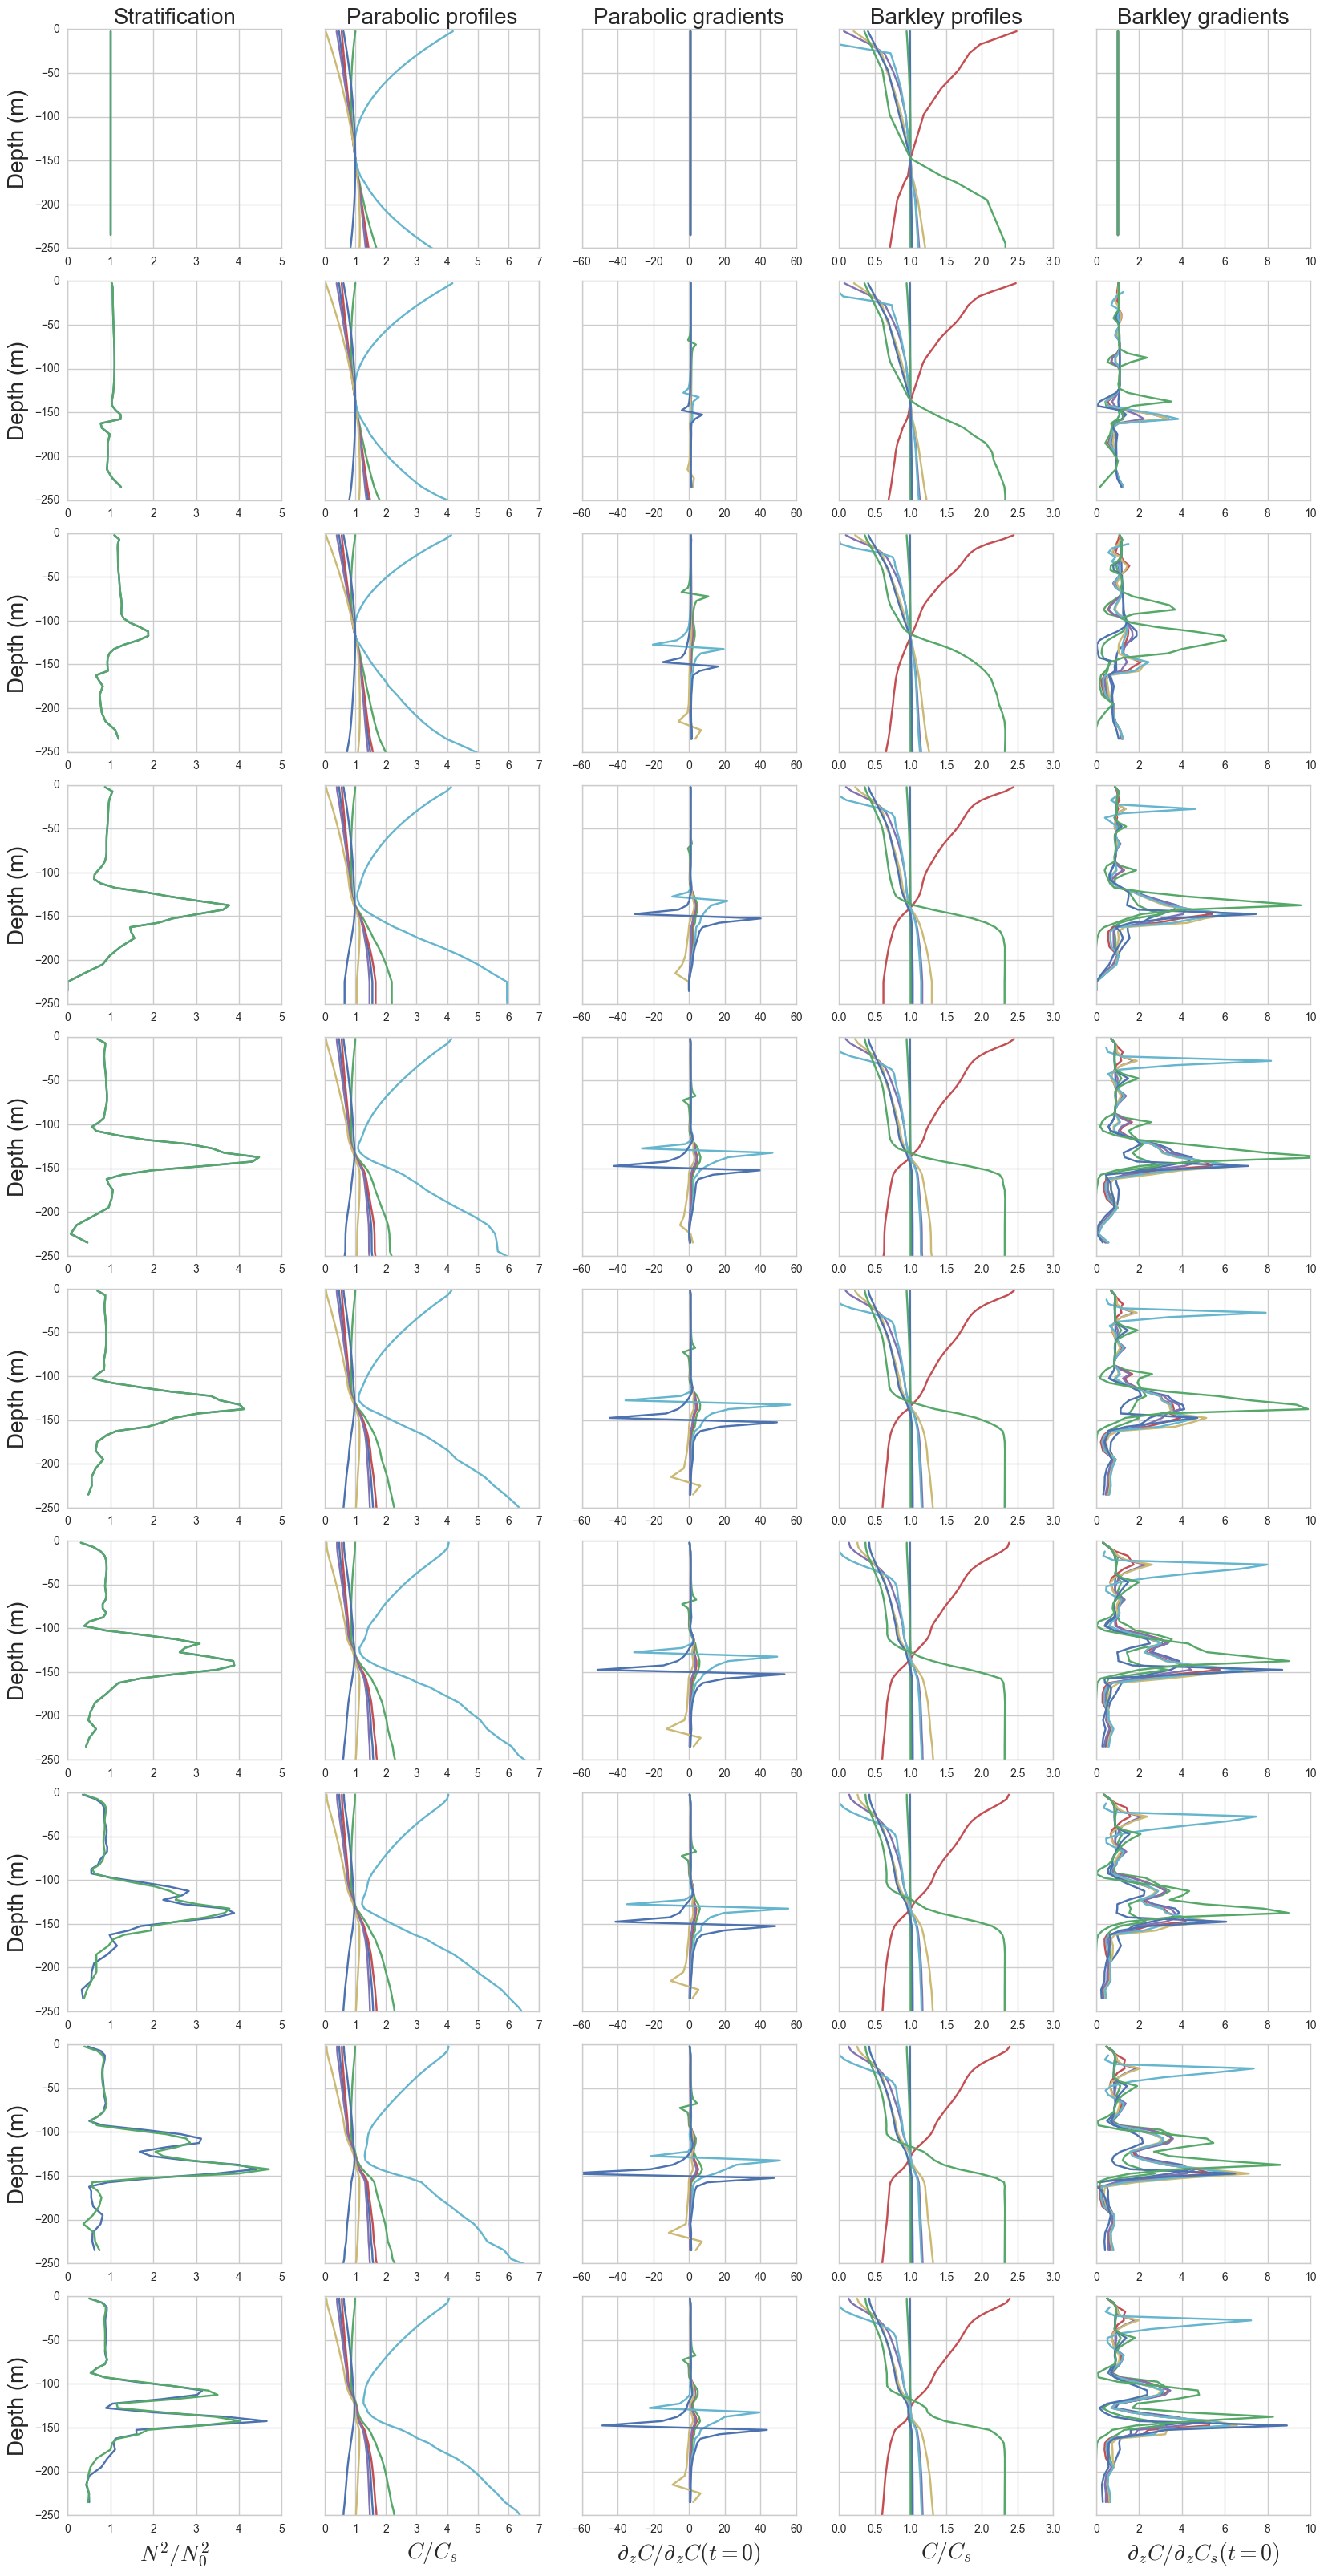

In [10]:
tracers_para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
tracers_bark = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']

times = [0,2,4,6,8,10,12,14,16,18]
nt = len(times)

fig = plt.figure(figsize=(20,40)) 
gs = gspec.GridSpec(nt, 5, hspace=0.15)


for trac in tracers_para:
    Tr = get_profile(PtracParaDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt,time in times:
        plt.subplot(gs[tt,1]).plot(Tr[tt,:]/Tr[0,29],depth)
        plt.subplot(gs[tt,2]).plot(dTr[tt,:]/dTr[0,:],depth[:-2],)
        plt.subplot(gs[tt,1]).set_xlim(0,7)
        plt.subplot(gs[tt,1]).set_ylim(-250,0)
        plt.subplot(gs[tt,2]).set_xlim(-60,60)
        plt.subplot(gs[tt,2]).set_ylim(-250,0)
        plt.subplot(gs[tt,1]).set_yticklabels([])
        plt.subplot(gs[tt,2]).set_yticklabels([])
        
for trac in tracers_bark:
    Tr = get_profile(PtracBarkDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt in range(nt):
        plt.subplot(gs[tt,3]).plot(Tr[tt,:]/Tr[0,29],depth)
        plt.subplot(gs[tt,4]).plot(dTr[tt,:]/dTr[0,:],depth[:-2],)
        plt.subplot(gs[tt,3]).set_xlim(0,3)
        plt.subplot(gs[tt,3]).set_ylim(-250,0)
        plt.subplot(gs[tt,4]).set_xlim(0,10)
        plt.subplot(gs[tt,4]).set_ylim(-250,0)
        plt.subplot(gs[tt,4]).set_yticklabels([])
        plt.subplot(gs[tt,3]).set_yticklabels([])
        
N2_bark = calc_N2(StateBarkDS,times,mask,drC,yi,xi)
N2_para = calc_N2(StateParaDS,times,mask,drC,yi,xi)
        
for tt in range(nt):
    plt.subplot(gs[tt,0]).plot((N2_bark[tt,:]/N2_bark[0,:]),depth[:-2],)
    plt.subplot(gs[tt,0]).plot((N2_para[tt,:]/N2_para[0,:]),depth[:-2],)

xlabels = ['$N^2/N^2_0$','$C/C_s$','$\partial_zC/\partial_zC(t=0)$','$C/C_s$','$\partial_zC/\partial_zC_s(t=0)$']
for plot, xlabel in zip(range(5),xlabels):
    plt.subplot(gs[nt-1,plot]).set_xlabel(xlabel,fontsize=20)

titles = ['Stratification','Parabolic profiles','Parabolic gradients','Barkley profiles','Barkley gradients']
for plot, title in zip(range(5),titles):
    plt.subplot(gs[0,plot]).set_title(title,fontsize=20)

for tt in range(nt):
    plt.subplot(gs[tt,0]).set_ylabel('Depth (m)',fontsize=20)
    plt.subplot(gs[tt,0]).set_xlim(0,5)
    plt.subplot(gs[tt,0]).set_ylim(-250,0)



## Normalized to inital values at shelf break

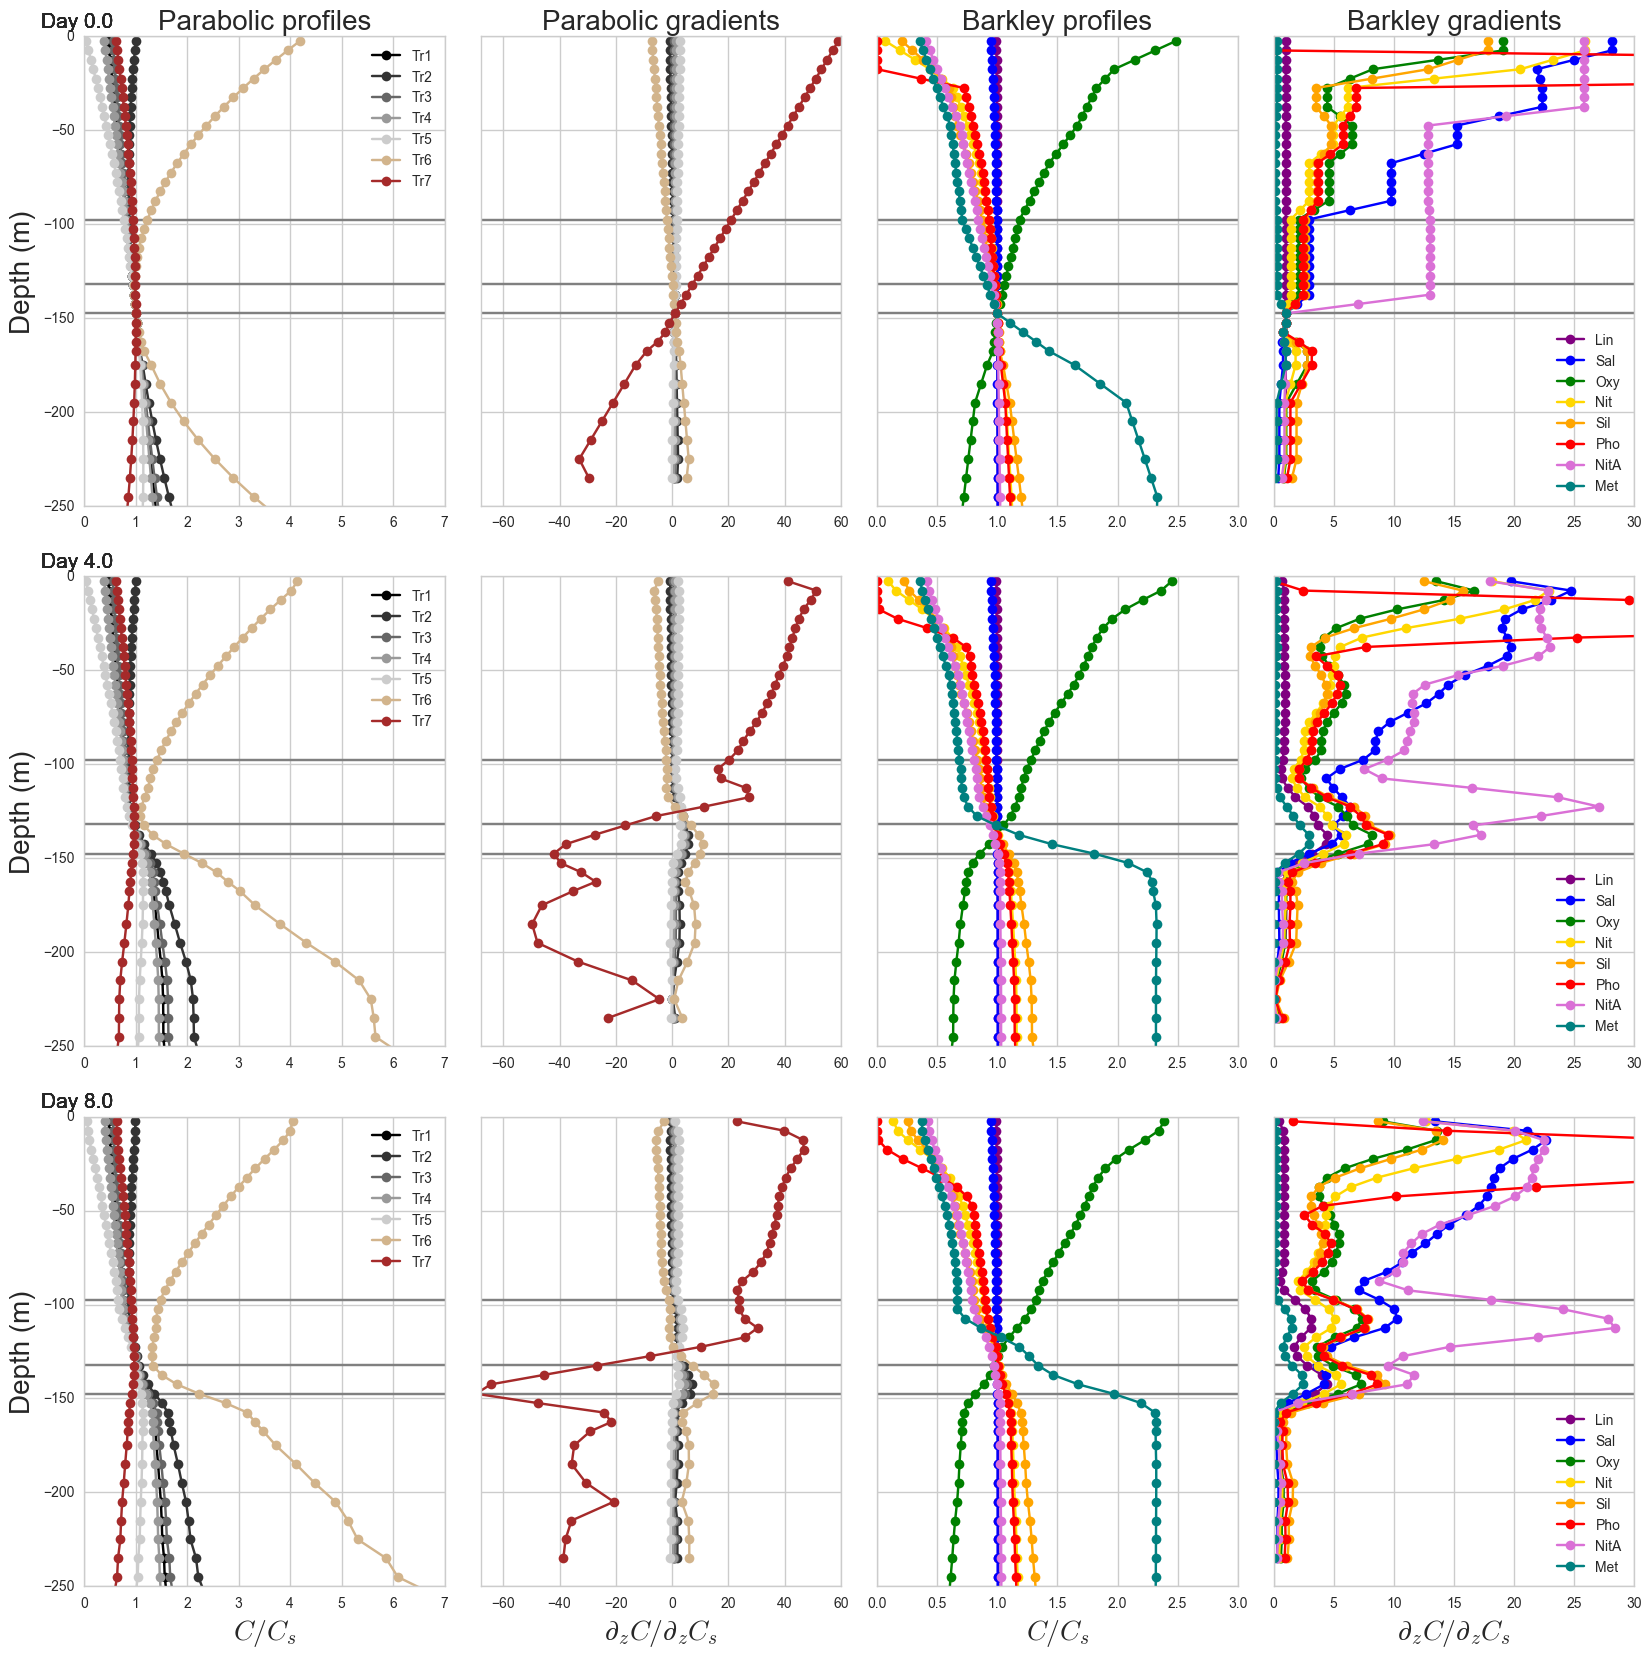

In [54]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']

Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']
labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['0.0','0.2','0.4','0.6','0.8','tan','brown'] 

tracers_para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
tracers_bark = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']

times = [0,8,16]
nt = len(times)

fig = plt.figure(figsize=(20,20)) 
gs = gspec.GridSpec(nt, 4, hspace=0.15, wspace=0.1)

for tt in range(nt):
    plt.subplot(gs[tt,0]).set_ylabel('Depth (m)',fontsize=20)
    for nn in range(4):
        plt.subplot(gs[tt,nn]).axhline(-147.5,color='gray')
        plt.subplot(gs[tt,nn]).axhline(-132.0,color='gray')
        plt.subplot(gs[tt,nn]).axhline(-97.5,color='gray')


for trac,lab,col in zip(tracers_para,labels_Para,colours_Para):
    Tr = get_profile(PtracParaDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt,time in zip(range(nt),times):
        plt.subplot(gs[tt,0]).plot(Tr[tt,:]/Tr[0,29],depth,'-o',color=col,label=lab)
        plt.subplot(gs[tt,1]).plot(dTr[tt,:]/dTr[0,29],depth[:-2],'-o',color=col)
        plt.subplot(gs[tt,0]).set_xlim(0,7)
        plt.subplot(gs[tt,0]).set_ylim(-250,0)
        plt.subplot(gs[tt,1]).set_xlim(-68,60)
        plt.subplot(gs[tt,1]).set_ylim(-250,0)
        plt.subplot(gs[tt,1]).set_yticklabels([])
        plt.subplot(gs[tt,0]).legend(loc=0) 
        plt.subplot(gs[tt,0]).text(-0.12, 1.02,'Day %1.1f' %(time/2), transform=plt.subplot(gs[tt,0]).transAxes,fontsize=15)
 
for trac,lab,col in zip(tracers_bark,labels_Bark,colours_Bark):
    Tr = get_profile(PtracBarkDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt in range(nt):
        plt.subplot(gs[tt,2]).plot(Tr[tt,:]/Tr[0,29],depth,'-o',color=col)
        plt.subplot(gs[tt,3]).plot(dTr[tt,:]/dTr[0,29],depth[:-2],'-o',label=lab,color=col)
        plt.subplot(gs[tt,2]).set_xlim(0,3)
        plt.subplot(gs[tt,2]).set_ylim(-250,0)
        plt.subplot(gs[tt,3]).set_xlim(0,30)
        plt.subplot(gs[tt,3]).set_ylim(-250,0)
        plt.subplot(gs[tt,3]).set_yticklabels([])
        plt.subplot(gs[tt,2]).set_yticklabels([])
        plt.subplot(gs[tt,3]).legend(loc=0)         
      

xlabels = ['$C/C_s$','$\partial_zC/\partial_zC_s$','$C/C_s$','$\partial_zC/\partial_zC_s$']
for plot, xlabel in zip(range(4),xlabels):
    plt.subplot(gs[nt-1,plot]).set_xlabel(xlabel,fontsize=20)

titles = ['Parabolic profiles','Parabolic gradients','Barkley profiles','Barkley gradients']
for plot, title in zip(range(4),titles):
    plt.subplot(gs[0,plot]).set_title(title,fontsize=20)

     


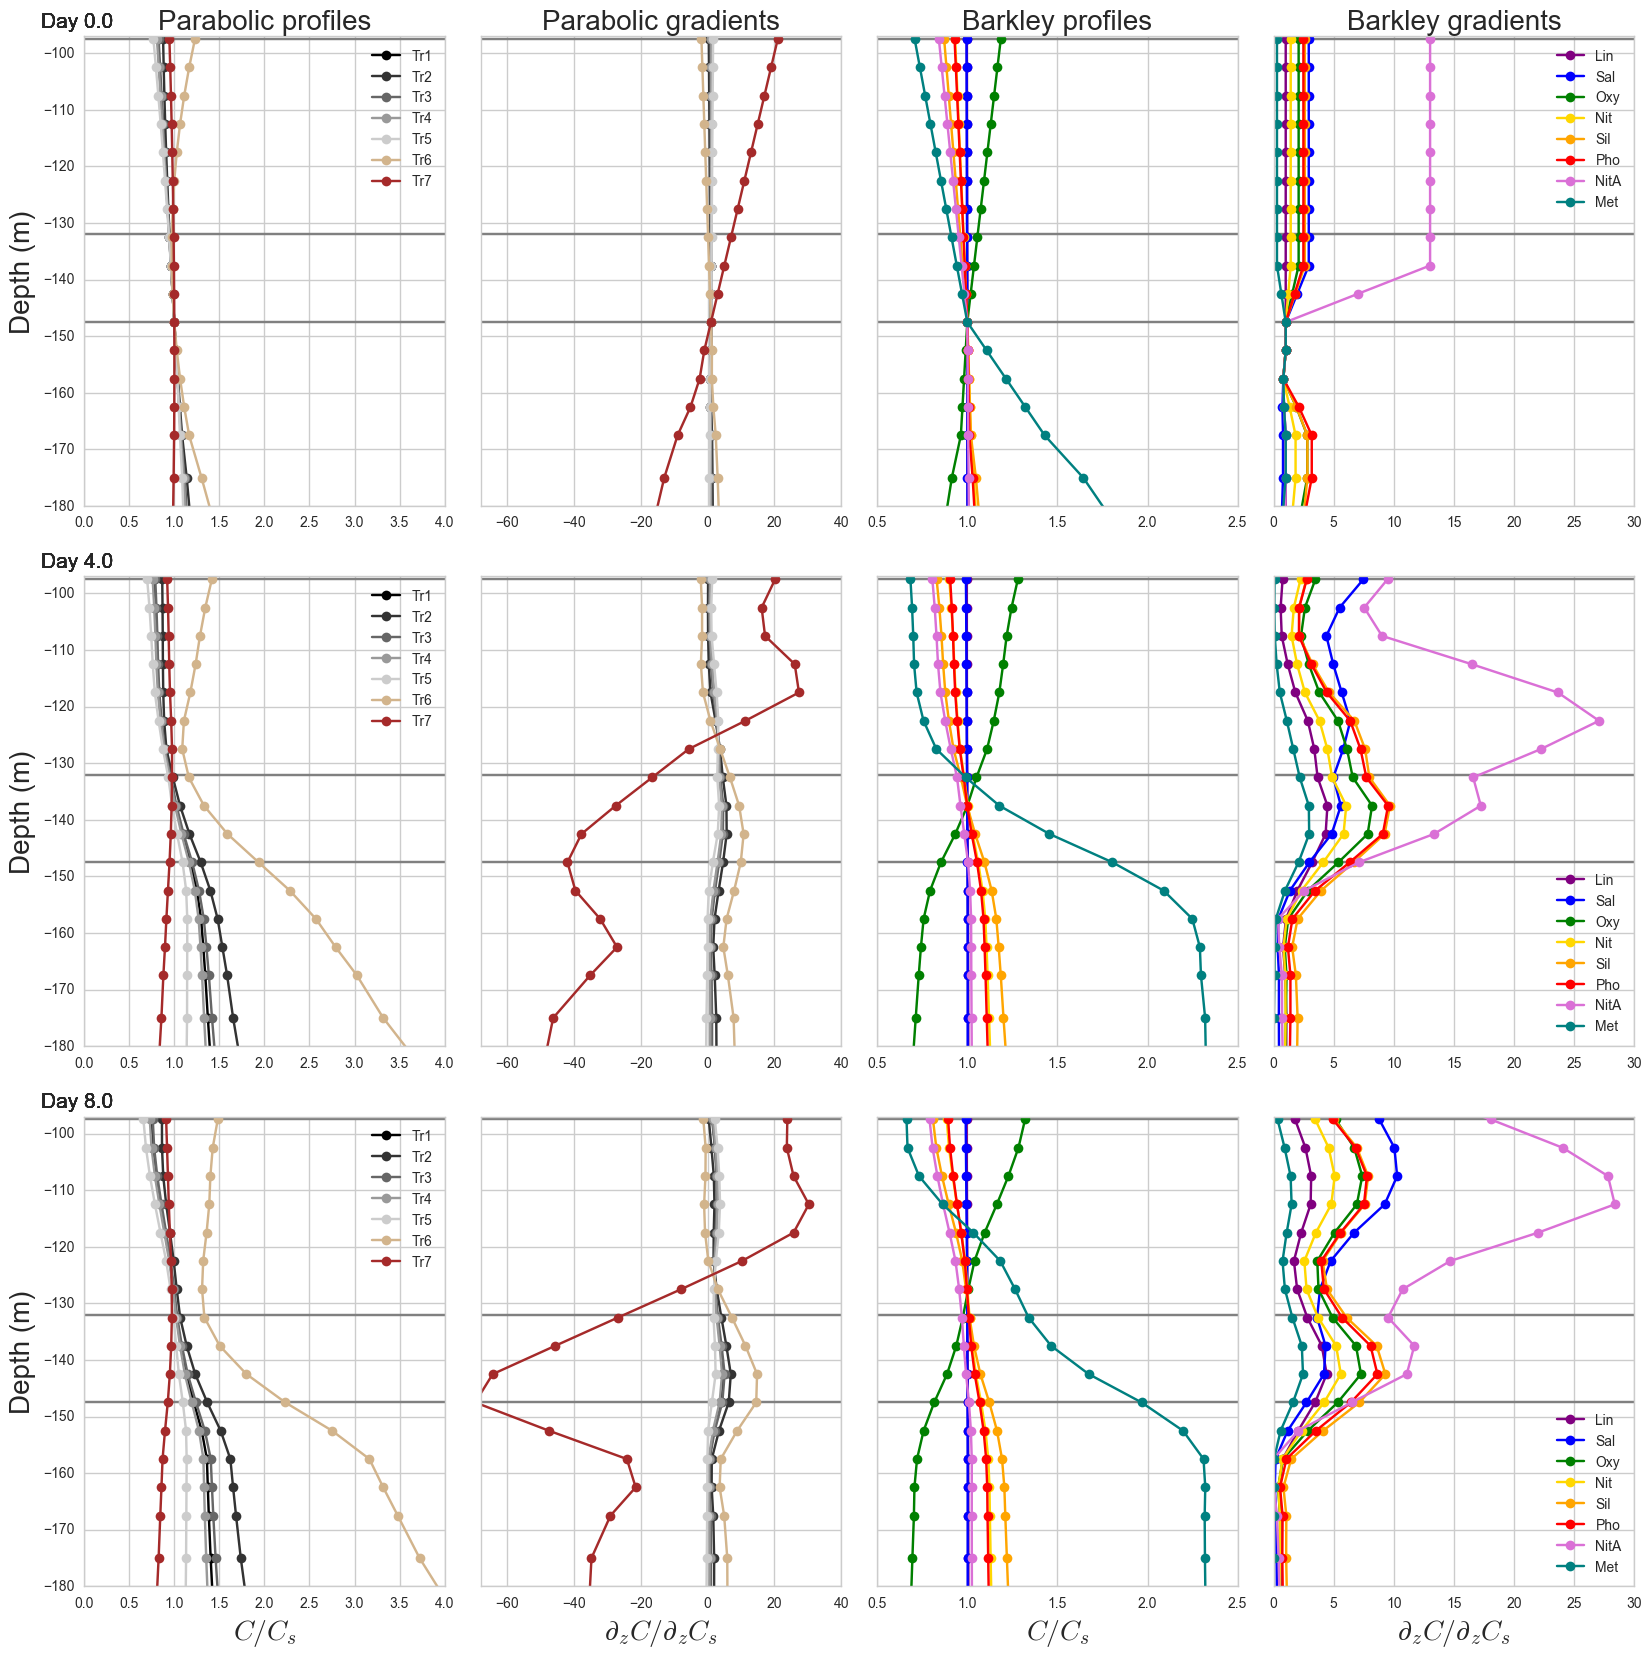

In [56]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']

Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']
labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['0.0','0.2','0.4','0.6','0.8','tan','brown'] 

tracers_para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
tracers_bark = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']

times = [0,8,16]
nt = len(times)

fig = plt.figure(figsize=(20,20)) 
gs = gspec.GridSpec(nt, 4, hspace=0.15, wspace=0.1)

for tt in range(nt):
    plt.subplot(gs[tt,0]).set_ylabel('Depth (m)',fontsize=20)
    for nn in range(4):
        plt.subplot(gs[tt,nn]).axhline(-147.5,color='gray')
        plt.subplot(gs[tt,nn]).axhline(-132.0,color='gray')
        plt.subplot(gs[tt,nn]).axhline(-97.5,color='gray')

for trac,lab,col in zip(tracers_para,labels_Para,colours_Para):
    Tr = get_profile(PtracParaDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt,time in zip(range(nt),times):
        plt.subplot(gs[tt,0]).plot(Tr[tt,:]/Tr[0,29],depth,'-o',color=col,label=lab)
        plt.subplot(gs[tt,1]).plot(dTr[tt,:]/dTr[0,29],depth[:-2],'-o',color=col)
        plt.subplot(gs[tt,0]).set_xlim(0,4)
        plt.subplot(gs[tt,0]).set_ylim(-180,-97.0)
        plt.subplot(gs[tt,1]).set_xlim(-68,40)
        plt.subplot(gs[tt,1]).set_ylim(-180,-97.0)
        plt.subplot(gs[tt,1]).set_yticklabels([])
        plt.subplot(gs[tt,0]).legend(loc=1) 
        plt.subplot(gs[tt,0]).text(-0.12, 1.02,'Day %1.1f' %(time/2), transform=plt.subplot(gs[tt,0]).transAxes,fontsize=15)

for trac,lab,col in zip(tracers_bark,labels_Bark,colours_Bark):
    Tr = get_profile(PtracBarkDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt in range(nt):
        plt.subplot(gs[tt,2]).plot(Tr[tt,:]/Tr[0,29],depth,'-o',color=col)
        plt.subplot(gs[tt,3]).plot(dTr[tt,:]/dTr[0,29],depth[:-2],'-o',label=lab,color=col)
        plt.subplot(gs[tt,2]).set_xlim(0.5,2.5)
        plt.subplot(gs[tt,2]).set_ylim(-180,-97.0)
        plt.subplot(gs[tt,3]).set_xlim(0,30)
        plt.subplot(gs[tt,3]).set_ylim(-180,-97.0)
        plt.subplot(gs[tt,3]).set_yticklabels([])
        plt.subplot(gs[tt,2]).set_yticklabels([])
        plt.subplot(gs[tt,3]).legend(loc=0)         
  

xlabels = ['$C/C_s$','$\partial_zC/\partial_zC_s$','$C/C_s$','$\partial_zC/\partial_zC_s$']
for plot, xlabel in zip(range(4),xlabels):
    plt.subplot(gs[nt-1,plot]).set_xlabel(xlabel,fontsize=20)

titles = ['Parabolic profiles','Parabolic gradients','Barkley profiles','Barkley gradients']
for plot, title in zip(range(4),titles):
    plt.subplot(gs[0,plot]).set_title(title,fontsize=20)


## Raw values of $\partial_zC$

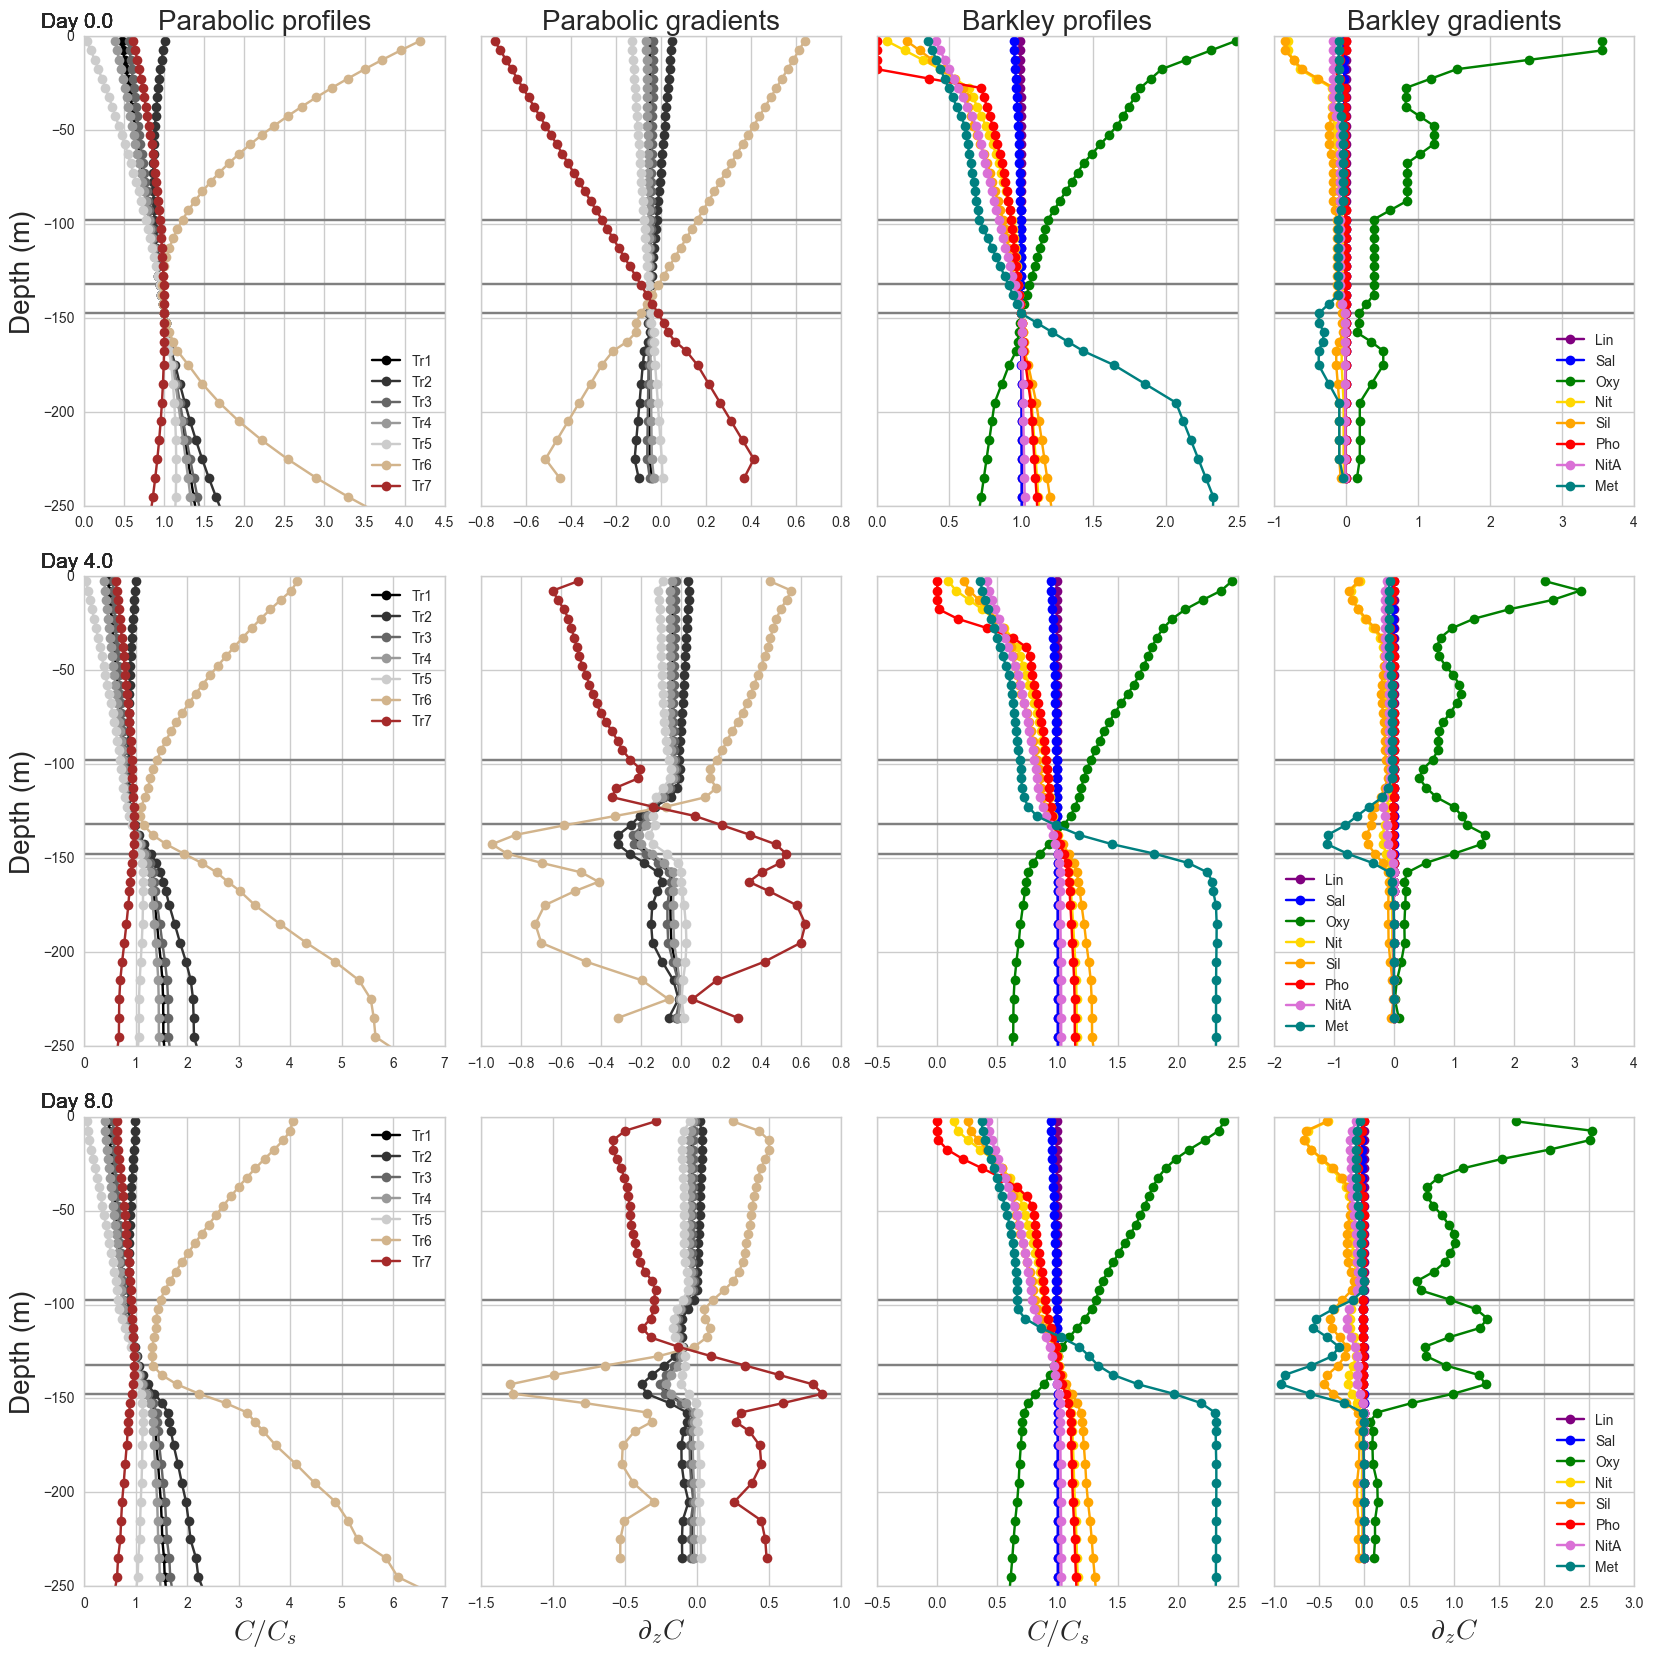

In [59]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']

Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']
labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['0.0','0.2','0.4','0.6','0.8','tan','brown'] 

tracers_para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
tracers_bark = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']

times = [0,8,16]
nt = len(times)

fig = plt.figure(figsize=(20,20)) 
gs = gspec.GridSpec(nt, 4, hspace=0.15, wspace=0.1)

for tt in range(nt):
    plt.subplot(gs[tt,0]).set_ylabel('Depth (m)',fontsize=20)
    for nn in range(4):
        plt.subplot(gs[tt,nn]).axhline(-147.5,color='gray')
        plt.subplot(gs[tt,nn]).axhline(-132.0,color='gray')
        plt.subplot(gs[tt,nn]).axhline(-97.5,color='gray')


for trac,lab,col in zip(tracers_para,labels_Para,colours_Para):
    Tr = get_profile(PtracParaDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt,time in zip(range(nt),times):
        plt.subplot(gs[tt,0]).plot(Tr[tt,:]/Tr[0,29],depth,'-o',color=col,label=lab)
        plt.subplot(gs[tt,1]).plot(dTr[tt,:],depth[:-2],'-o',color=col)
        #plt.subplot(gs[tt,0]).set_xlim(0,7)
        plt.subplot(gs[tt,0]).set_ylim(-250,0)
        #plt.subplot(gs[tt,1]).set_xlim(-68,60)
        plt.subplot(gs[tt,1]).set_ylim(-250,0)
        plt.subplot(gs[tt,1]).set_yticklabels([])
        plt.subplot(gs[tt,0]).legend(loc=0) 
        plt.subplot(gs[tt,0]).text(-0.12, 1.02,'Day %1.1f' %(time/2), transform=plt.subplot(gs[tt,0]).transAxes,fontsize=15)
 
for trac,lab,col in zip(tracers_bark,labels_Bark,colours_Bark):
    Tr = get_profile(PtracBarkDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt in range(nt):
        plt.subplot(gs[tt,2]).plot(Tr[tt,:]/Tr[0,29],depth,'-o',color=col)
        plt.subplot(gs[tt,3]).plot(dTr[tt,:],depth[:-2],'-o',label=lab,color=col)
        #plt.subplot(gs[tt,2]).set_xlim(0,3)
        plt.subplot(gs[tt,2]).set_ylim(-250,0)
        #plt.subplot(gs[tt,3]).set_xlim(0,30)
        plt.subplot(gs[tt,3]).set_ylim(-250,0)
        plt.subplot(gs[tt,3]).set_yticklabels([])
        plt.subplot(gs[tt,2]).set_yticklabels([])
        plt.subplot(gs[tt,3]).legend(loc=0)         
      

xlabels = ['$C/C_s$','$\partial_zC$','$C/C_s$','$\partial_zC$']
for plot, xlabel in zip(range(4),xlabels):
    plt.subplot(gs[nt-1,plot]).set_xlabel(xlabel,fontsize=20)

titles = ['Parabolic profiles','Parabolic gradients','Barkley profiles','Barkley gradients']
for plot, title in zip(range(4),titles):
    plt.subplot(gs[0,plot]).set_title(title,fontsize=20)

     


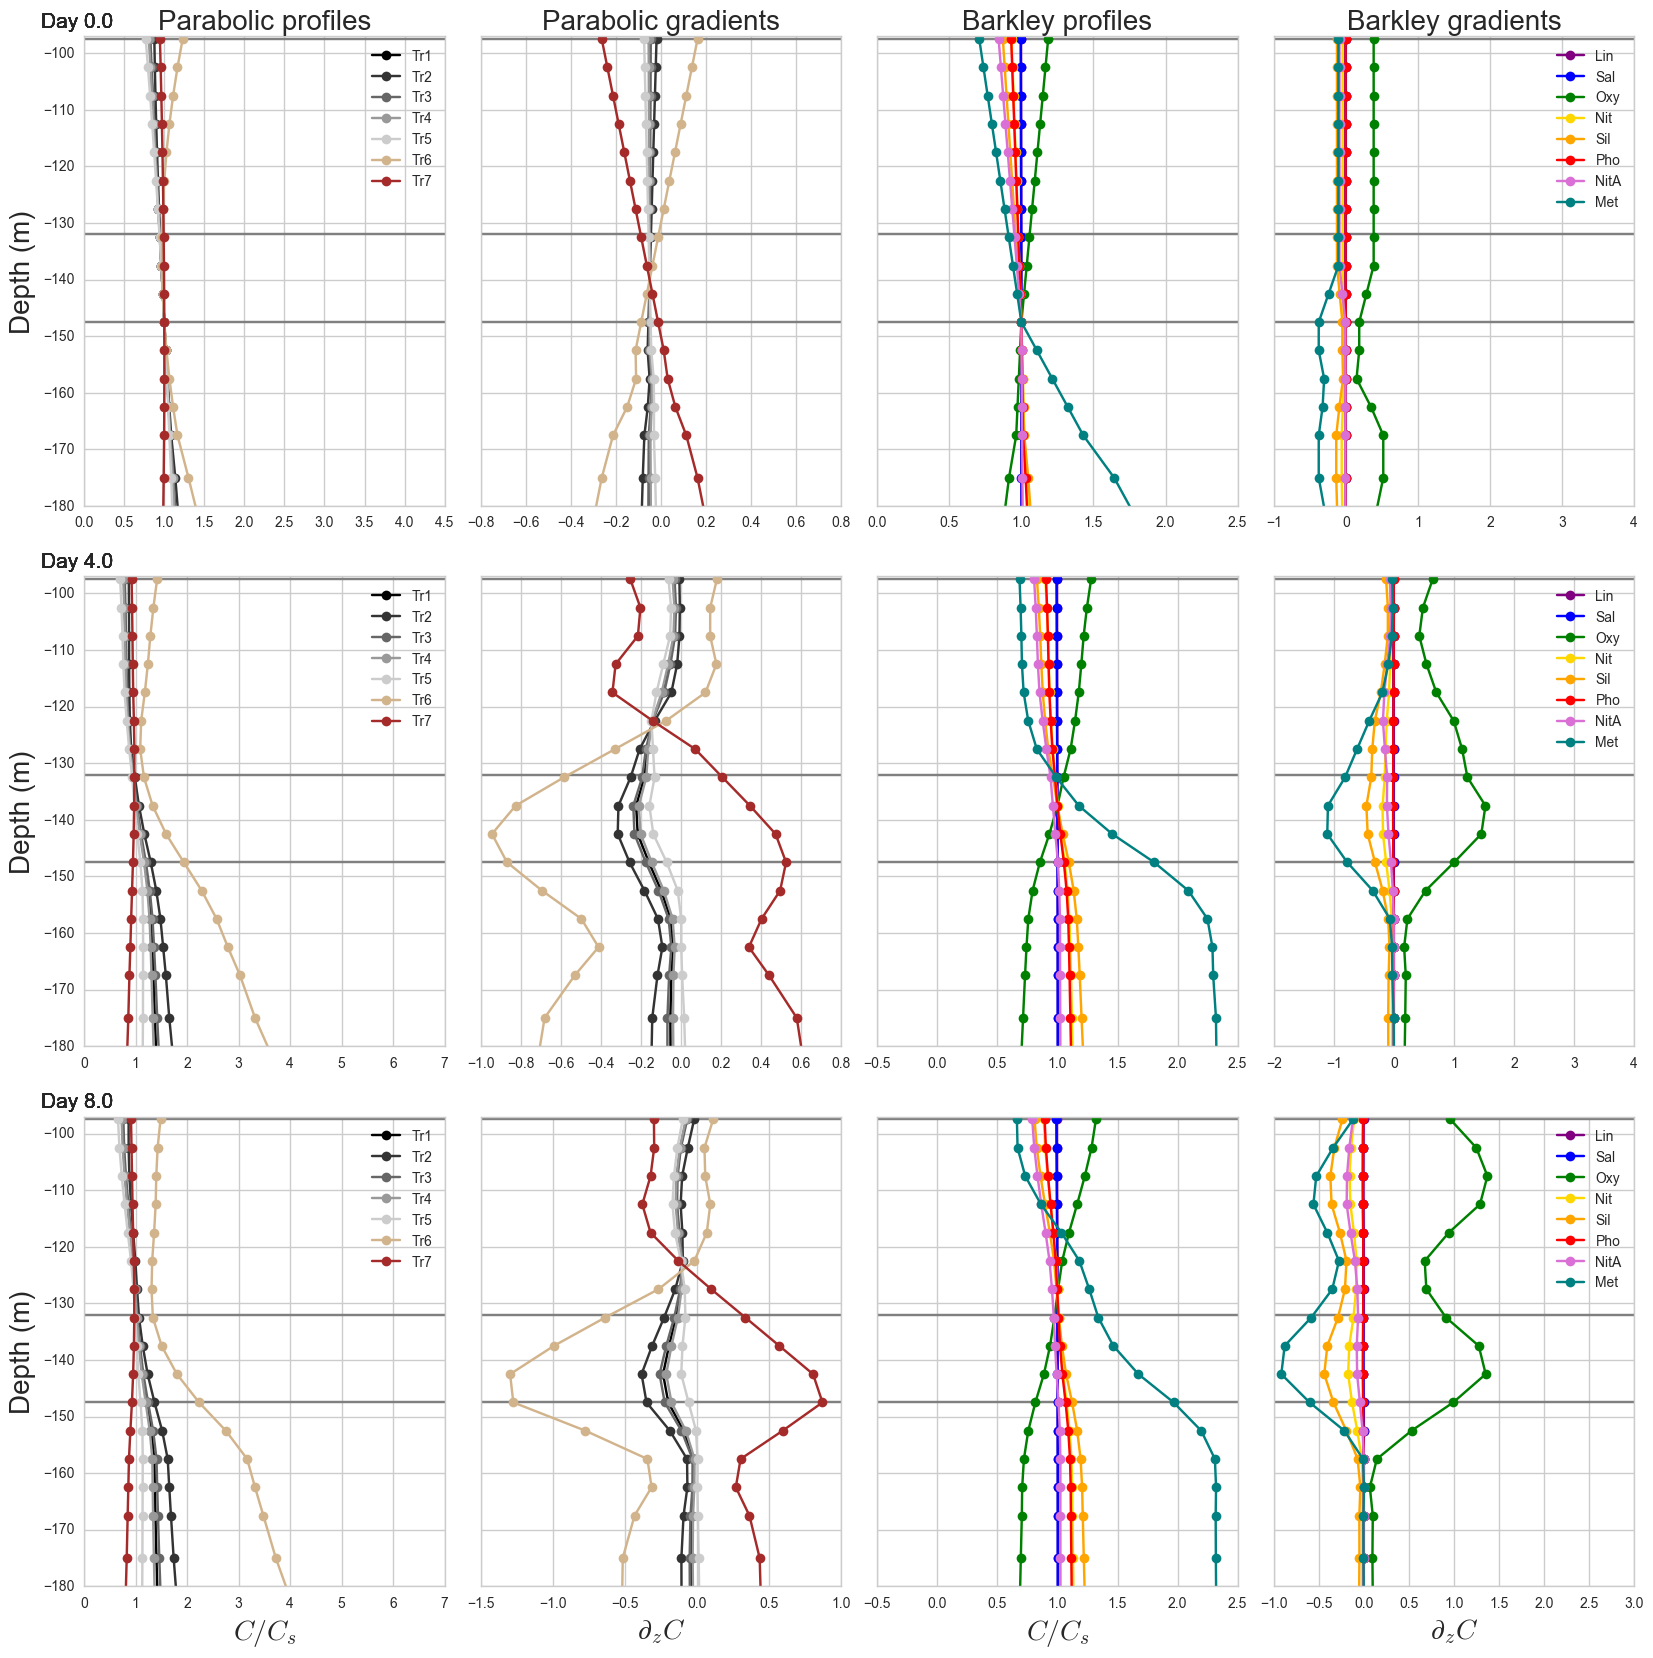

In [60]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']

Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']
labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['0.0','0.2','0.4','0.6','0.8','tan','brown'] 

tracers_para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
tracers_bark = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']

times = [0,8,16]
nt = len(times)

fig = plt.figure(figsize=(20,20)) 
gs = gspec.GridSpec(nt, 4, hspace=0.15, wspace=0.1)

for tt in range(nt):
    plt.subplot(gs[tt,0]).set_ylabel('Depth (m)',fontsize=20)
    for nn in range(4):
        plt.subplot(gs[tt,nn]).axhline(-147.5,color='gray')
        plt.subplot(gs[tt,nn]).axhline(-132.0,color='gray')
        plt.subplot(gs[tt,nn]).axhline(-97.5,color='gray')


for trac,lab,col in zip(tracers_para,labels_Para,colours_Para):
    Tr = get_profile(PtracParaDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt,time in zip(range(nt),times):
        plt.subplot(gs[tt,0]).plot(Tr[tt,:]/Tr[0,29],depth,'-o',color=col,label=lab)
        plt.subplot(gs[tt,1]).plot(dTr[tt,:],depth[:-2],'-o',color=col)
        plt.subplot(gs[tt,0]).set_xlim(0,7)
        plt.subplot(gs[tt,0]).set_ylim(-180,-97)
        #plt.subplot(gs[tt,1]).set_xlim(-68,60)
        plt.subplot(gs[tt,1]).set_ylim(-180,-97)
        plt.subplot(gs[tt,1]).set_yticklabels([])
        plt.subplot(gs[tt,0]).legend(loc=0) 
        plt.subplot(gs[tt,0]).text(-0.12, 1.02,'Day %1.1f' %(time/2), transform=plt.subplot(gs[tt,0]).transAxes,fontsize=15)
 
for trac,lab,col in zip(tracers_bark,labels_Bark,colours_Bark):
    Tr = get_profile(PtracBarkDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
        
    for tt in range(nt):
        plt.subplot(gs[tt,2]).plot(Tr[tt,:]/Tr[0,29],depth,'-o',color=col)
        plt.subplot(gs[tt,3]).plot(dTr[tt,:],depth[:-2],'-o',label=lab,color=col)
        #plt.subplot(gs[tt,2]).set_xlim(0,3)
        plt.subplot(gs[tt,2]).set_ylim(-180,-97)
        #plt.subplot(gs[tt,3]).set_xlim(0,30)
        plt.subplot(gs[tt,3]).set_ylim(-180,-97)
        plt.subplot(gs[tt,3]).set_yticklabels([])
        plt.subplot(gs[tt,2]).set_yticklabels([])
        plt.subplot(gs[tt,3]).legend(loc=0)         
      

xlabels = ['$C/C_s$','$\partial_zC$','$C/C_s$','$\partial_zC$']
for plot, xlabel in zip(range(4),xlabels):
    plt.subplot(gs[nt-1,plot]).set_xlabel(xlabel,fontsize=20)

titles = ['Parabolic profiles','Parabolic gradients','Barkley profiles','Barkley gradients']
for plot, title in zip(range(4),titles):
    plt.subplot(gs[0,plot]).set_title(title,fontsize=20)

     
